In [ ]:
!wget --no-check-certificate \
https://github.com/yooerizkilab/TubesAI-Dataset-Fruits/raw/master/Dataset.zip \
  -O /tmp/Dataset.zip

--2021-12-31 07:13:41--  https://github.com/yooerizkilab/TubesAI-Dataset-Fruits/raw/master/Dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yooerizkilab/TubesAI-Dataset-Fruits/master/Dataset.zip [following]
--2021-12-31 07:13:42--  https://raw.githubusercontent.com/yooerizkilab/TubesAI-Dataset-Fruits/master/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6254063 (6.0M) [application/zip]
Saving to: ‘/tmp/Dataset.zip’

/tmp/Dataset.zip    100%[===================>]   5.96M  --.-KB/s    in 0.04s   

2021-12-31 07:13:42 (151 MB/s) - ‘/tmp/Dataset.zip’ saved [6254063/6254063]



In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import zipfile

local_zip = '/tmp/Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

In [ ]:
apple_train_path = train_dir + '/apple'
mango_train_pat = train_dir + '/mango'
apple_val_path = val_dir + '/apple'
mango_val_path = val_dir + '/mango'

apple_len_train = len(os.listdir(apple_train_path))
mango_len_train = len(os.listdir(mango_train_pat))
apple_len_val = len(os.listdir(apple_val_path))
mango_len_val = len(os.listdir(mango_val_path))

print("jumlah dataset Training : ", apple_len_train + mango_len_train)
print("jumlah dataset validasi : ", apple_len_val + mango_len_val)
print("\n\n")
print("jumlah train kelas Mask : ", apple_len_train)
print("jumlah train kelas No Mask : ", mango_len_train)
print("jumlah validasi kelas Mask : ", apple_len_val)
print("jumlah validasi kelas No Mask : ", mango_len_val)

jumlah dataset Training :  100
jumlah dataset validasi :  40



jumlah train kelas Mask :  50
jumlah train kelas No Mask :  50
jumlah validasi kelas Mask :  20
jumlah validasi kelas No Mask :  20


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 100 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten,Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')        
directory_to_save_best_model_file = '/content/gdrive/MyDrive/Colab Notebooks/Tubes/model_drop_batch_weight_from_callback.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [ ]:
VGG16 = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

553476096/553467096 [==============================] - 4s 0us/step


In [ ]:
output = VGG16.get_layer(index = -1).output  
output = Flatten()(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output) 

In [ ]:
VGG16_model = Model(VGG16.input, output)

VGG16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', 
                        metrics =['accuracy'])

In [ ]:
history = VGG16_model.fit(
      train_generator,
      steps_per_epoch=10,  # images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=10,  #  images = batch_size * steps
      callbacks = [callbacks, best_model])

Epoch 1/100
 5/10 [==============>...............] - ETA: 2:57 - loss: 0.6961 - accuracy: 0.5300WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1000 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/MyDrive/Colab Notebooks/Tubes/model_drop_batch_weight_from_callback.h5
10/10 [==============================] - 223s 19s/step - loss: 0.6961 - accuracy: 0.5300 - val_loss: 0.6932 - val_accuracy: 0.5000


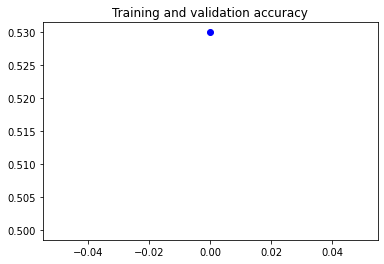

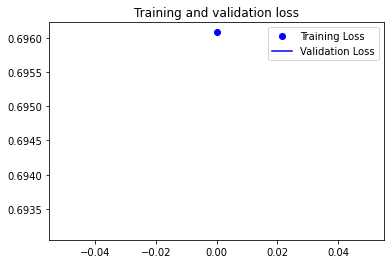

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns
sns.set(style='whitegrid')

In [ ]:
from keras.models import load_model
model_path = '/content/gdrive/MyDrive/Colab Notebooks/Tubes/model_drop_batch_weight_from_callback.h5'
model = load_model(model_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 40 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy  : 0.5
Precision : 0.25
f1Score : 0.3333333333333333
[[20  0]
 [20  0]]


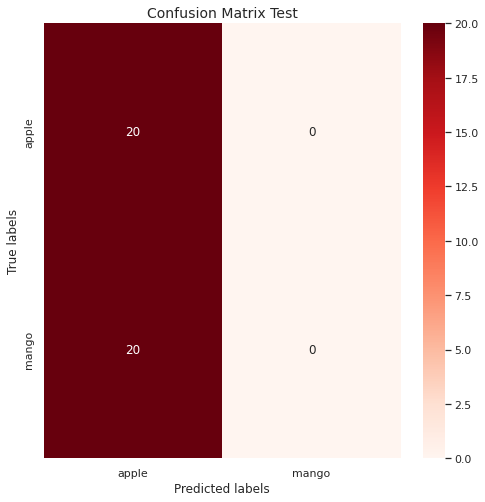

In [ ]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

height=224; width=224
batch_size=20

test_datagen = ImageDataGenerator(rescale=1./255)

TESTING_DIR = '/tmp/Dataset/validation'

test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size=batch_size,                                                             
                                                  target_size=(height, width),
                                                  class_mode= None,
                                                  shuffle=False
                                                  )

predictions = model.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()